# Набор тестов и проверок, что все правильно считается в неустойчивостях

In [1]:
from IPython.display import HTML
from IPython.display import Image
from PIL import Image as ImagePIL

%pylab
%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%run ../../utils/load_notebook.py # импортируем функцию загрузки ноутбука

In [3]:
from instabilities import * # загружаем функции

importing Jupyter notebook from instabilities.ipynb
Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [4]:
%run ../../utils/show_notebook.py 

In [5]:
show_notebook("instabilities.ipynb") # показываем функции из ноутбука, чтобы можно было подглядеть в определение

Для случая бесконечного тонкого диска: $$\kappa=\frac{3}{R}\frac{d\Phi}{dR}+\frac{d^2\Phi}{dR^2}$$
где $\Phi$ - гравпотенциал, однако его знать не надо, т.к. есть проще формула: $$\kappa=\sqrt{2}\frac{\vartheta_c}{R}\sqrt{1+\frac{R}{\vartheta_c}\frac{d\vartheta_c}{dR}}$$

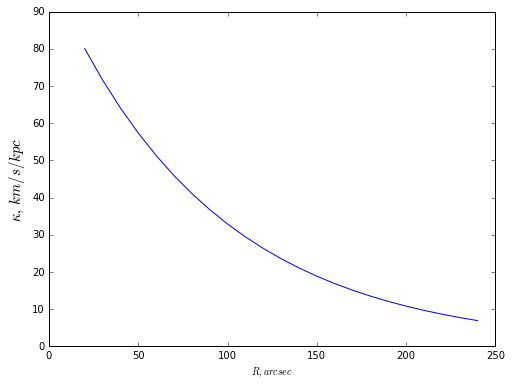

In [6]:
def model_kappa(R):
    return 100.*np.exp(-R/90.)

test_points = np.arange(20., 250., 10.)

fig = plt.figure(figsize=[8, 6])
plt.plot(test_points, model_kappa(test_points), '-')
plt.xlabel('$R, arcsec$')
plt.ylabel('$\kappa,\, km/s/kpc$', fontsize=15)
plt.show()

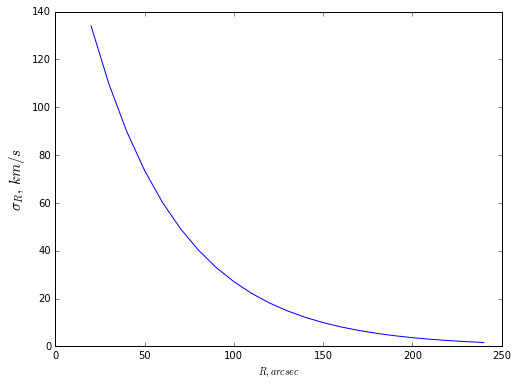

In [7]:
def model_sigmaR(R):
    return 200.*np.exp(-R/50.)

fig = plt.figure(figsize=[8, 6])
plt.plot(test_points, model_sigmaR(test_points), '-')
plt.xlabel('$R, arcsec$')
plt.ylabel('$\sigma_R,\, km/s$', fontsize=15)
plt.show()

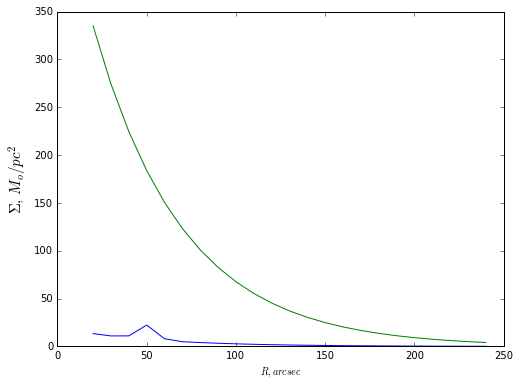

In [8]:
def model_star(R):
    return 500.*np.exp(-R/50.)

def model_gas(R):
    return 20.*np.exp(-R/50.) + 15.*np.exp(-(R-50.)**2/50.)

fig = plt.figure(figsize=[8, 6])
plt.plot(test_points, model_gas(test_points), '-')
plt.plot(test_points, model_star(test_points), '-')
plt.xlabel('$R, arcsec$')
plt.ylabel('$\Sigma,\, M_{o}/pc^2$', fontsize=15)
plt.show()

# Одножидкостный
Устойчиво, когда > 1:
$$Q_g = \frac{\Sigma_g^{cr}}{\Sigma_g}=\frac{\kappa c_g}{\pi G \Sigma_g}$$
$$Q_s = \frac{\Sigma_s^{cr}}{\Sigma_s}=\frac{\sigma_R}{\sigma_R^{min}}=\frac{\kappa \sigma_R}{3.36 G \Sigma_s}$$

In [9]:
sound_vel = 6  #скорость звука в газе, км/с

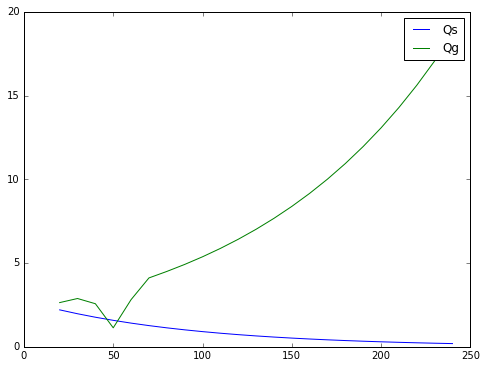

In [10]:
fig = plt.figure(figsize=[8, 6])
plt.plot(test_points, [Qs(epicycl=epicycl, sigma=sigma, star_density=star_density) for (epicycl, sigma, star_density) in zip(
        model_kappa(test_points), model_sigmaR(test_points), model_star(test_points))], label='Qs')
plt.plot(test_points, [Qg(epicycl=epicycl, sound_vel=sound_vel_, gas_density=gas_density) for 
                       (epicycl, sound_vel_, gas_density) in zip(model_kappa(test_points), 
                                                                 [sound_vel]*len(test_points), 
                                                                 model_gas(test_points))], label='Qg')
plt.legend()
plt.show()

# Двухжидкостная:

Кинетическое приближение:
$$\frac{1}{Q_{\mathrm{eff}}}=\frac{2}{Q_{\mathrm{s}}}\frac{1}{\bar{k}}\left[1-e^{-\bar{k}^{2}}I_{0}(\bar{k}^{2})\right]+\frac{2}{Q_{\mathrm{g}}}s\frac{\bar{k}}{1+\bar{k}^{2}s^{2}}>1\,$$

Гидродинамическое приближение:
$$\frac{2\,\pi\, G\, k\,\Sigma_{\mathrm{s}}}{\kappa+k^{2}\sigma_{\mathrm{s}}}+\frac{2\,\pi\, G\, k\,\Sigma_{\mathrm{g}}}{\kappa+k^{2}c_{\mathrm{g}}}>1$$ или $$\frac{1}{Q_{\mathrm{eff}}}=\frac{2}{Q_{\mathrm{s}}}\frac{\bar{k}}{1+\bar{k}^{2}}+\frac{2}{Q_{\mathrm{g}}}s\frac{\bar{k}}{1+\bar{k}^{2}s^{2}}>1$$ для безразмерного волнового числа ${\displaystyle \bar{k}\equiv\frac{k\,\sigma_{\mathrm{s}}}{\kappa}},\, s=c/\sigma$

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>
проверим, что на каком-то участке значения inverse_kinem_Qeff_from_k и inverse_hydro_Qeff_from_k совпадают

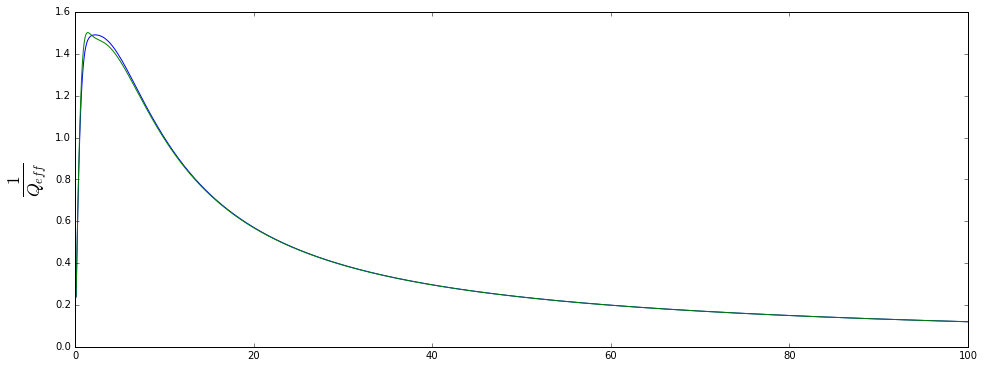

In [11]:
fig = plt.figure(figsize=[16, 6])
pp_ = np.linspace(0.1, 100., 1000)
plt.plot(pp_, [inverse_hydro_Qeff_from_k(l, Qg=1., Qs=1., s=0.2) for l in pp_], '-')
plt.plot(pp_, [inverse_kinem_Qeff_from_k(l, Qg=1., Qs=1., s=0.2) for l in pp_], '-')
plt.ylabel(r'$\frac{1}{Q_{eff}}$', fontsize=25)
plt.show()

Видно, что различия есть (как и показывал Rafikov), но с хорошей точностью значения совпадают.

Зависимость от величины параметров:

In [12]:
inv_qss = np.arange(0.01, 1.2, 0.1)
inv_qgs = np.arange(0.01, 1.2, 0.1)

inv_qeffs = []

for qg in inv_qgs:
    for qs in inv_qss:
        inv_qeff = max([inverse_kinem_Qeff_from_k(l, Qg=1./qg, Qs=1./qs, s=0.2) for l in np.arange(0.1, 10000., 1.0)])
        inv_qeffs.append(inv_qeff)

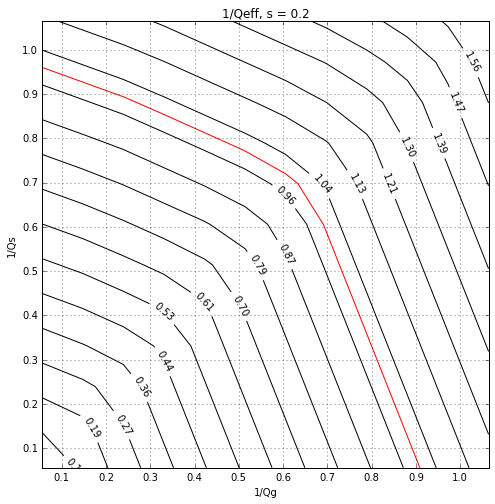

In [13]:
fig = plt.figure(figsize=[8, 8])

ax1 = fig.add_subplot(111)
qeffs = np.array(inv_qeffs).reshape(len(inv_qgs), len(inv_qgs))
levels = np.linspace(qeffs.min(), qeffs.max(), 20)

cset=ax1.contour(qeffs, levels, hold='on', colors = 'k', origin='lower', extent=[inv_qgs[0],inv_qgs[-1],inv_qss[0],inv_qss[-1]])
ax1.clabel(cset, inline=1, fontsize=10, fmt='%1.2f')
ax1.grid()
ax1.set_xlabel('1/Qg')
ax1.set_ylabel('1/Qs')
ax1.set_title('1/Qeff, s = 0.2')
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))

levels = np.array([1.0])
cset=ax1.contour(qeffs, levels, hold='on', colors = 'r', origin='lower', extent=[inv_qgs[0],inv_qgs[-1],inv_qss[0],inv_qss[-1]])

plt.show()

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>воспроизвести следующую иллюстрацию из Rafikov 2001 (Fig.3)

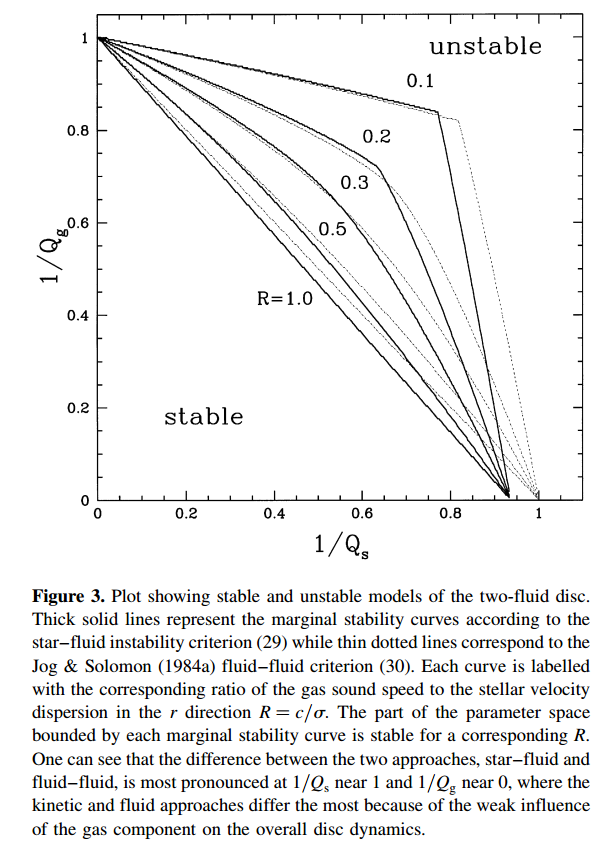

In [14]:
Image('rafikov_fig3.png')

In [15]:
inv_qss = np.arange(0.01, 1.2, 0.1)
inv_qgs = np.arange(0.01, 1.2, 0.1)

s_params = [1.0, 0.5, 0.3, 0.2, 0.1]
inv_qeffs_k = [[],[],[],[],[]]
inv_qeffs_h = [[],[],[],[],[]]

for ind, s in enumerate(s_params):
    for qg in inv_qgs:
        for qs in inv_qss:
            inv_qeff = max([inverse_kinem_Qeff_from_k(l, Qg=1./qg, Qs=1./qs, s=s) for l in np.arange(0.1, 10000., 1.0)])
            inv_qeffs_k[ind].append(inv_qeff)
            inv_qeff = max([inverse_hydro_Qeff_from_k(l, Qg=1./qg, Qs=1./qs, s=s) for l in np.arange(0.1, 10000., 1.0)])
            inv_qeffs_h[ind].append(inv_qeff)

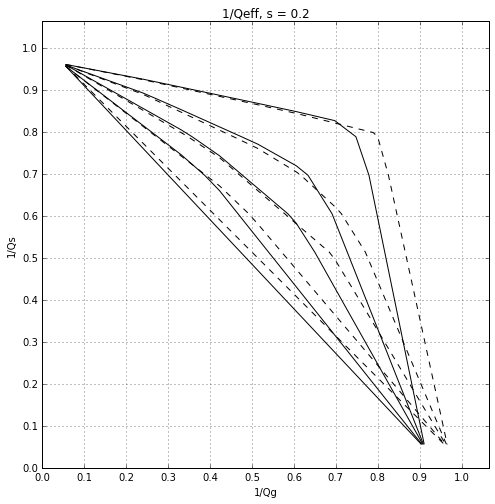

In [16]:
fig = plt.figure(figsize=[8, 8])

ax1 = fig.add_subplot(111)
levels = np.array([1.])

for ind, s in enumerate(s_params):
    qeffs = np.array(inv_qeffs_h[ind]).reshape(len(inv_qgs), len(inv_qgs))
    cset=ax1.contour(qeffs, levels, hold='on', colors = 'k', origin='lower', 
                     extent=[inv_qgs[0],inv_qgs[-1],inv_qss[0],inv_qss[-1]], linestyles='dashed')
    qeffs = np.array(inv_qeffs_k[ind]).reshape(len(inv_qgs), len(inv_qgs))
    cset=ax1.contour(qeffs, levels, hold='on', colors = 'k', origin='lower', 
                     extent=[inv_qgs[0],inv_qgs[-1],inv_qss[0],inv_qss[-1]])
ax1.grid()
ax1.set_xlabel('1/Qg')
ax1.set_ylabel('1/Qs')
ax1.set_title('1/Qeff, s = 0.2')
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))

plt.show()

Успешно!

# Нахождение максимума функции:

В гидродинамическом приближении вообще просто - это многочлен
$$\frac{2}{Q_{\mathrm{s}}}\frac{\bar{k}}{1+\bar{k}^{2}}+\frac{2}{Q_{\mathrm{g}}}s\frac{\bar{k}}{1+\bar{k}^{2}s^{2}}>1$$
и у него можно найти максимум методами Sympy, взяв производную:

In [17]:
from sympy import *
x = Symbol('x', real=True)
a = 1.5
f = 2./a*x/(1+x**2) + 2/0.9*0.4*x/(1+x**2 * 0.4**2)
roots = solve(f.diff(), x)
print roots
print max([f.evalf(subs={x:r}) for r in roots])

[-1.85855358154608, 1.85855358154608]
1.62034285003827


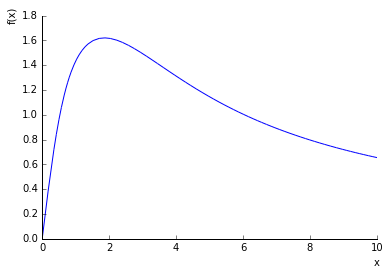

In [18]:
from sympy.plotting import plot
plot(f, (x, 0., 10.))

In [19]:
findInvHydroQeffSympy(1.32, 1.22, 0.52)

(1.408446000988677, 1.49668341702704)

Второй метод - тупо перебор по сетке:

In [20]:
findInvHydroQeffBrute(1.32, 1.22, 0.52, np.arange(0.01, 300., 0.01))

(1.4100000000000001, 1.4966826880822235)

Последний метод - используя производную, запускать brentq на нужном промежутке:

In [21]:
findInvHydroQeffBrentq(1.32, 1.22, 0.52, np.arange(0.01, 300., 0.01))

(1.4084460009886812, 1.496683417027044)

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>
все три метода должны работать и давать почти одинаковые результаты на случайных данных.  

In [22]:
cases_n = 1000
test_cases = zip(np.random.uniform(0.01, 3., cases_n), 
                 np.random.uniform(0.01, 3., cases_n), 
                 np.abs(np.random.normal(0.01, 0.5, cases_n)))

In [23]:
test_cases[0:10]

[(0.46590634709598588, 2.195401062730074, 0.4577795604792968),
 (1.6856797233429963, 2.9857988221438978, 0.03361509402127872),
 (2.4378383945209969, 1.9381950746086971, 0.71032872826613636),
 (1.439191818170283, 1.570165255204824, 0.81454629915080223),
 (2.0097893940272669, 0.46676098323732246, 0.54957897491578811),
 (2.7021777615670568, 2.0005488702185859, 0.048587842247888501),
 (0.55202016032025203, 2.2711912705100601, 0.17031920753056703),
 (0.94317892462366748, 1.8827633727852395, 0.25490235087831092),
 (2.3081298858531469, 1.9526260405642728, 0.46565157296700804),
 (1.4572992434684517, 0.63900453781634048, 0.91694709294906118)]

In [24]:
%time bren = [findInvHydroQeffBrentq(case[0], case[1], case[2], np.arange(0.01, 60000., 1.)) for case in test_cases]

Wall time: 4min 16s


In [25]:
%time sym = [findInvHydroQeffSympy(case[0], case[1], case[2]) for case in test_cases]

Wall time: 7min 22s


In [26]:
%time bru = [findInvHydroQeffBrute(case[0], case[1], case[2], np.arange(0.01, 3000., 0.01)) for case in test_cases]

WARNING! For Qs=0.842660154861 Qg=0.724569189699 s=0.000234916421128 root of max near the max of k-range
Wall time: 12min 26s


In [27]:
%time bru = [findInvHydroQeffBrute(c[0], c[1], c[2], np.arange(b[0]-100., b[0]+100., 0.001)) for c, b in zip(test_cases, bren)]

Wall time: 8min 2s


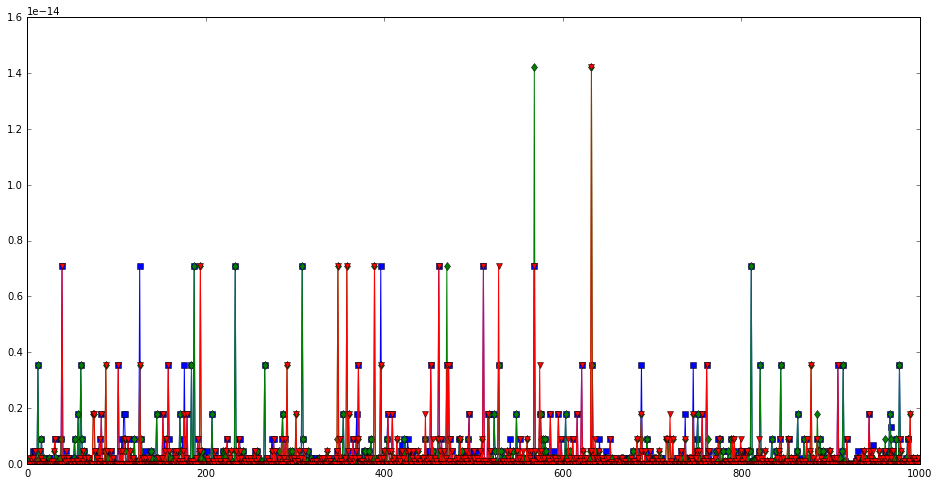

In [28]:
fig = plt.figure(figsize=[16, 8])
plt.plot(range(cases_n), abs(np.array(zip(*bren)[1])-np.array(zip(*bru)[1])), 's-')
plt.plot(range(cases_n), abs(np.array(zip(*bren)[1])-np.array(zip(*sym)[1])), 'd-')
plt.plot(range(cases_n), abs(np.array(zip(*sym)[1])-np.array(zip(*bru)[1])), 'v-')
plt.show()

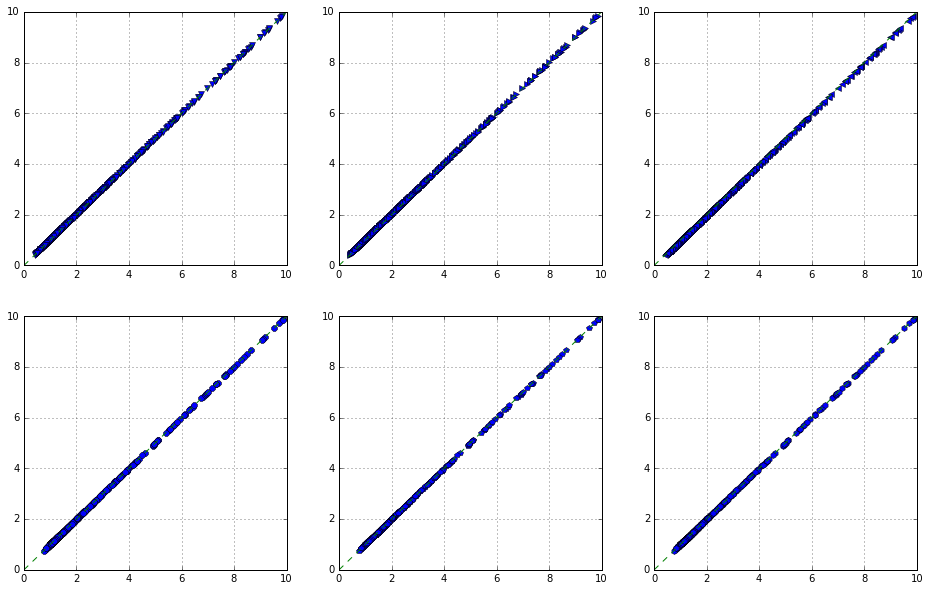

In [29]:
fig, axes = plt.subplots(2, 3, figsize=[16, 10])
axes[0][0].plot(zip(*sym)[1], zip(*bru)[1], 'v')
axes[0][1].plot(zip(*sym)[1], zip(*bren)[1], '>')
axes[0][2].plot(zip(*bren)[1], zip(*bru)[1], '<')

axes[1][0].plot(zip(*sym)[0], zip(*bru)[0], '8')
axes[1][1].plot(zip(*sym)[0], zip(*bren)[0], 'p')
axes[1][2].plot(zip(*bren)[0], zip(*bru)[0], 'h')

for ax in axes:
    for a in ax:
        a.set_xlim(0., 10.)
        a.set_ylim(0., 10.)
        a.grid()
        a.plot([0,10], [0, 10], '--')
plt.show()

Внешнее согласие отличное.

Теперь кинематическое приближение:
$$\frac{2}{Q_{\mathrm{s}}}\frac{1}{\bar{k}}\left[1-e^{-\bar{k}^{2}}I_{0}(\bar{k}^{2})\right]+\frac{2}{Q_{\mathrm{g}}}s\frac{\bar{k}}{1+\bar{k}^{2}s^{2}}>1\,$$
Тут сложнее, честно уже не решить. остается два способа - брутфорсом и brentq, производная известна.

In [30]:
findInvKinemQeffBrute(1.32, 1.22, 0.52, np.arange(0.01, 300., 0.01))

(1.3, 1.5278157625496003)

In [31]:
findInvKinemQeffBrentq(1.32, 1.22, 0.52, np.arange(0.01, 300., 0.01))

(1.3012816962470588, 1.5278164121945141)

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>оба метода должны давать схожие величины и работать в принципе

In [32]:
cases_n = 1000
test_cases = zip(np.random.uniform(0.01, 3., cases_n), 
                 np.random.uniform(0.01, 3., cases_n), 
                 np.abs(np.random.normal(0.01, 0.5, cases_n)))

In [33]:
test_cases[0:10]

[(2.9816301250366029, 0.49583480891652859, 0.50679046379497839),
 (2.4546699444881042, 2.2081201057179007, 0.034452973748545251),
 (2.5373262448757834, 0.56041404738584999, 0.21219789505497341),
 (2.7595149207194245, 0.54472571428973338, 0.37995760059045336),
 (2.3631763592386861, 2.0123314345868781, 0.24750093410065591),
 (2.9186558079909353, 2.3848753894318402, 0.15991386706971089),
 (1.4969430951231046, 2.5105768114111662, 0.49298576757316248),
 (0.29186782067183092, 1.9526461798016765, 0.71353884108189758),
 (0.14696390709855933, 2.0559147869484455, 0.89347274746895133),
 (2.8028372130470709, 0.24344467998663694, 0.23645961488818681)]

In [34]:
%time bren = [findInvKinemQeffBrentq(case[0], case[1], case[2], np.arange(0.01, 60000., 1.)) for case in test_cases]

Wall time: 8min 34s


In [35]:
%time bru = [findInvKinemQeffBrute(case[0], case[1], case[2], np.arange(0.01, 3000., 0.01)) for case in test_cases]

Wall time: 18min 49s


In [36]:
%time bru = [findInvKinemQeffBrute(c[0], c[1], c[2], np.arange(b[0]-100., b[0]+100., 0.001)) for c, b in zip(test_cases, bren)]

Wall time: 12min 40s


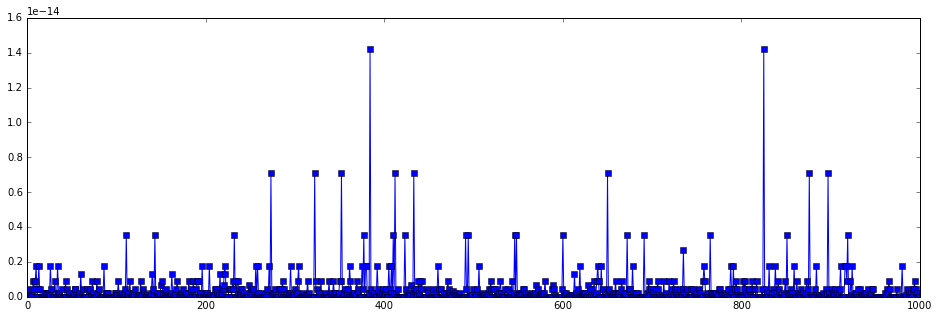

In [37]:
fig = plt.figure(figsize=[16, 5])
plt.plot(range(cases_n), abs(np.array(zip(*bren)[1])-np.array(zip(*bru)[1])), 's-')
plt.show()

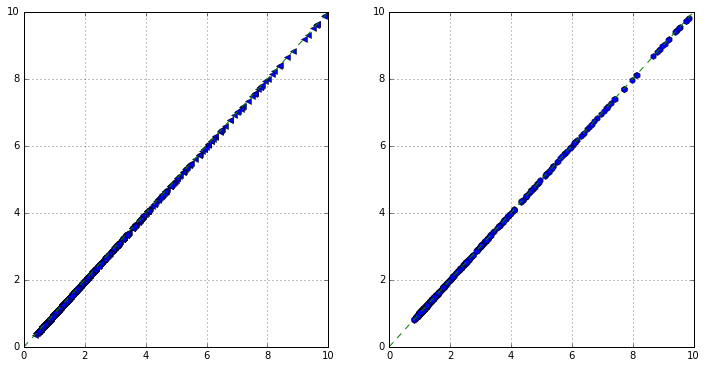

In [38]:
fig, axes = plt.subplots(1, 2, figsize=[12, 6])
axes[0].plot(zip(*bren)[1], zip(*bru)[1], '<')
axes[1].plot(zip(*bren)[0], zip(*bru)[0], 'h')

for ax in axes:
    ax.set_xlim(0., 10.)
    ax.set_ylim(0., 10.)
    ax.grid()
    ax.plot([0,10], [0, 10], '--')
plt.show()

Работает

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>Кинематические решения должны быть не очень далеко от гидродинамических - Kinem ~ Hydro 

In [39]:
cases_n = 200
test_cases = zip(np.random.uniform(0.01, 3., cases_n), 
                 np.random.uniform(0.01, 3., cases_n), 
                 np.abs(np.random.normal(0.01, 0.5, cases_n)))

In [40]:
test_cases[0:10]

[(2.9974977463186541, 0.67174053464992034, 0.00028979580141474254),
 (0.27586990963569941, 1.9891871268476615, 0.17832811773198312),
 (1.2431541173938563, 1.2658035904694929, 0.56687704808003869),
 (0.12360972017731459, 2.9365423924979299, 0.30774064769198683),
 (1.6237534243173859, 1.0358788334940487, 0.21076809551684791),
 (1.2612691708436041, 0.46286099591573066, 0.49896674494201582),
 (0.47145867798130348, 2.8478533353855702, 0.34794639546405076),
 (2.7616221056932218, 2.0884660215131254, 0.50281815084474069),
 (2.4560504424927392, 0.42193433374259398, 0.2913354237251522),
 (1.8025734919806378, 1.1782129525195597, 0.21234063995262512)]

In [41]:
%time kin = [findInvKinemQeffBrentq(case[0], case[1], case[2], np.arange(0.01, 60000., 1.)) for case in test_cases]

Wall time: 1min 46s


In [42]:
%time hyd = [findInvHydroQeffBrentq(case[0], case[1], case[2], np.arange(0.01, 60000., 1.)) for case in test_cases]

Wall time: 53.9 s


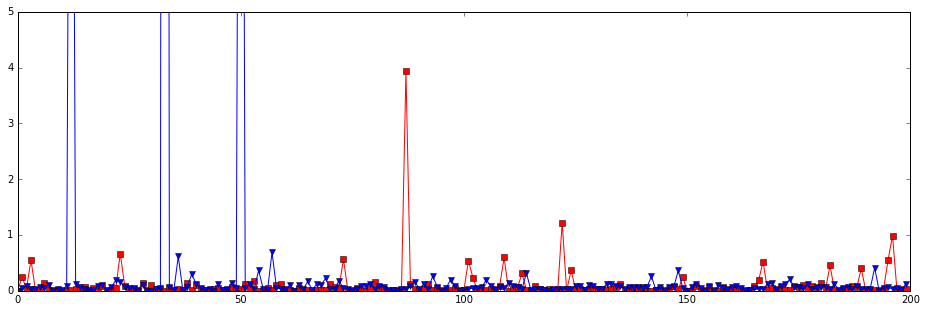

In [43]:
fig = plt.figure(figsize=[16, 5])
plt.plot(range(cases_n), abs(np.array(zip(*kin)[1])-np.array(zip(*hyd)[1])), 's-', color='red')
plt.plot(range(cases_n), abs(np.array(zip(*kin)[0])-np.array(zip(*hyd)[0])), 'v-')
plt.ylim(0, 5.)
plt.show()

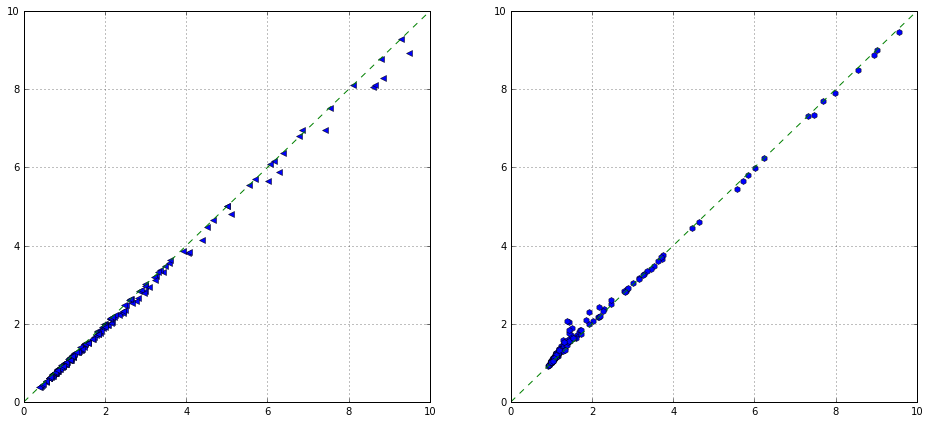

In [44]:
fig, axes = plt.subplots(1, 2, figsize=[16, 7])
axes[0].plot(zip(*kin)[1], zip(*hyd)[1], '<')
axes[1].plot(zip(*kin)[0], zip(*hyd)[0], 'h')

for ax in axes:
    ax.set_xlim(0., 10.)
    ax.set_ylim(0., 10.)
    ax.grid()
    ax.plot([0,10], [0, 10], '--')
plt.show()

Видно, что максимум иногда съезжает и Q иногда различается, но в целом все достаточно близко.

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>
$$Q_{2F} \le Q_{1F}$$

In [45]:
# используем сосчитанные выше кейсы
%time qgs = [1./case[1] for case in test_cases]

Wall time: 0 ns


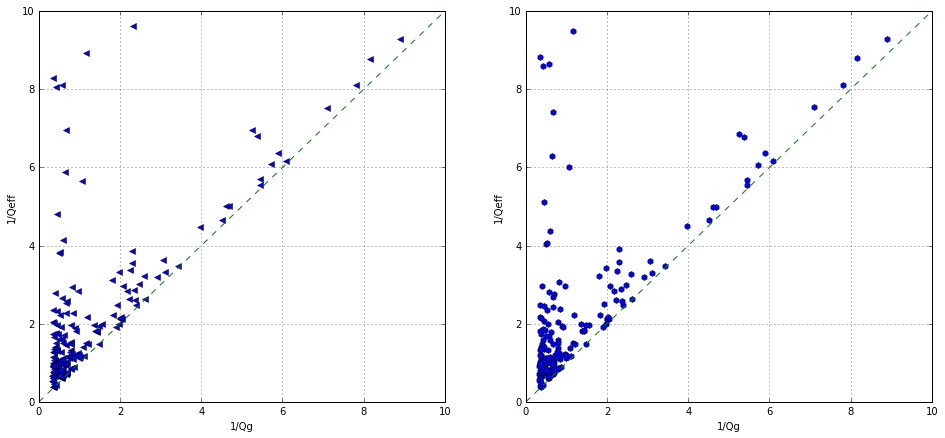

In [46]:
fig, axes = plt.subplots(1, 2, figsize=[16, 7])
axes[0].plot(qgs, zip(*hyd)[1], '<')
axes[1].plot(qgs, zip(*kin)[1], 'h')

for ax in axes:
    ax.set_xlim(0., 10.)
    ax.set_ylim(0., 10.)
    ax.grid()
    ax.plot([0,10], [0, 10], '--')
    ax.set_xlabel('1/Qg')
    ax.set_ylabel('1/Qeff')
plt.show()

Верно

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>
воспроизвести график из следующей иллюстрации Rafikov 2001

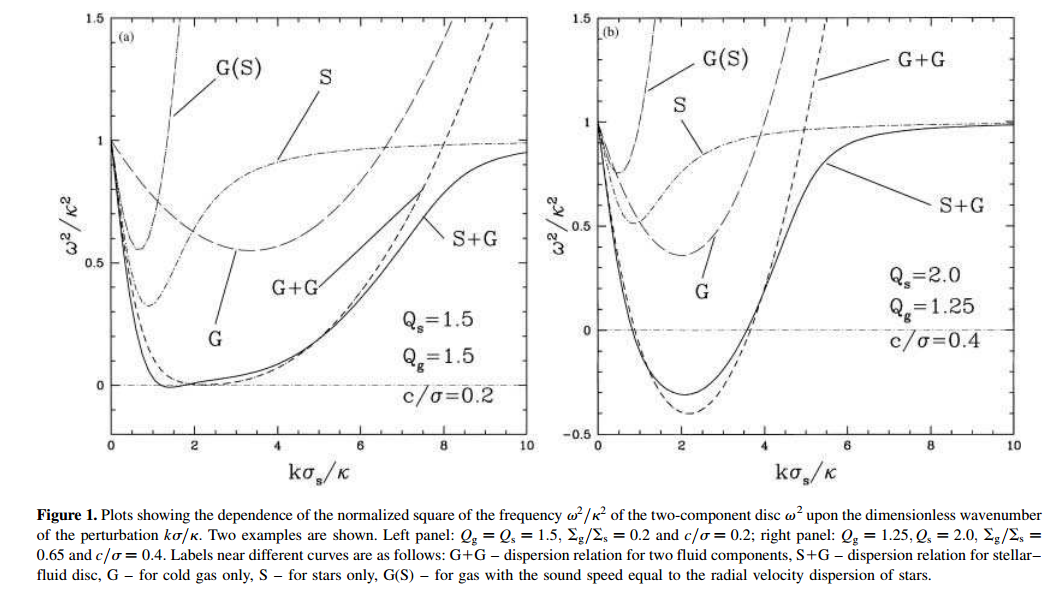

In [47]:
Image('rafikov_fig1.png')

Не слишком полезно с общей точки зрения (т.к. зависимость немого отличается), но показательно. 
Зависимости от квадрата возмущения следующие (видоизменненое уравнение 22 в оригинальной статье):
$$\frac{2}{Q_{\mathrm{s}}}\frac{1}{\bar{k}}\left[1-e^{-\bar{k}^{2}}I_{0}(\bar{k}^{2})\right]\frac{1}{1 - \omega^2/\kappa^2}+\frac{2}{Q_{\mathrm{g}}}s\frac{\bar{k}}{1+\bar{k}^{2}s^{2} - \omega^2/\kappa^2}=1\,$$
для газа: $$\bar{k}^2s^2 + 1 - \frac{2}{Q_{\mathrm{g}}}s\bar{k} = \omega^2/\kappa^2$$
для звезд: $$1 - \frac{2}{Q_{\mathrm{s}}}\frac{1}{\bar{k}}\left[1-e^{-\bar{k}^{2}}I_{0}(\bar{k}^{2})\right] = \omega^2/\kappa^2$$

In [48]:
from scipy.special import i0e, i1e
from scipy.optimize import fsolve

qg = 1.5
qs = 1.5
s = 0.2

tp = np.arange(0.1, 10., 0.1)

def twofl_w2(l):
    global qg, qs, s, dimlK
    return 2. / dimlK / qs * (1 - i0e(dimlK ** 2)) * (1. / (1 - l)) + 2*s*dimlK / qg / (1 + dimlK**2 * s**2 - l) - 1.

sol = []
for d in tp:
    dimlK = d
    initial_guess = 0.
    solution = fsolve(twofl_w2, initial_guess)
    sol.append(solution)

def star_w2(qs, dimlK):
    return 1. - 2. / dimlK / qs * (1 - i0e(dimlK ** 2))

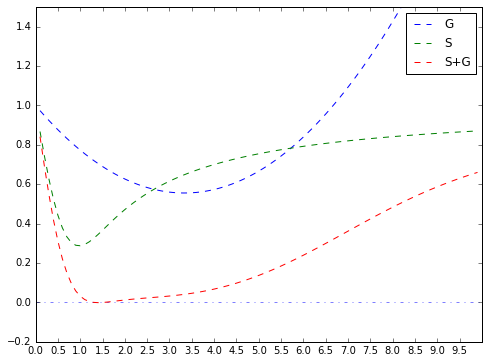

In [49]:
cold_gas = lambda l: l**2 * s**2 + 1. - 2./qg * s * l

fig = plt.figure(figsize=[8, 6])
plt.axhline(y=0, ls='-.', alpha=0.5)
plt.plot(tp, map(cold_gas, tp), '--', label='G')
plt.plot(tp, [star_w2(1.5, x) for x in tp], '--', label='S')
plt.plot(tp, sol, '--', label='S+G')
plt.xlim(0, 10)
plt.ylim(-0.2, 1.5)
plt.legend()
plt.xticks(np.arange(0, 10, 0.5))
plt.show()

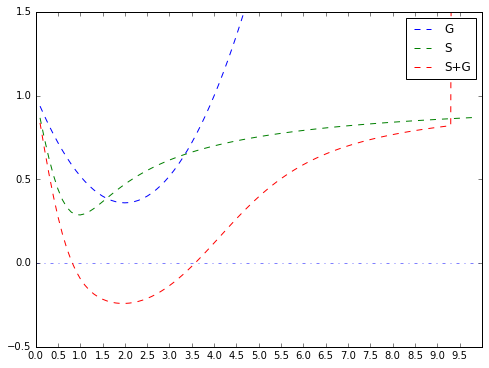

In [50]:
qg = 1.25
qs = 2.0
s = 0.4

sol = []
for d in tp:
    dimlK = d
    initial_guess = 0.
    solution = fsolve(twofl_w2, initial_guess)
    sol.append(solution)
    
fig = plt.figure(figsize=[8, 6])
plt.axhline(y=0, ls='-.', alpha=0.5)
plt.plot(tp, map(cold_gas, tp), '--', label='G')
plt.plot(tp, [star_w2(1.5, x) for x in tp], '--', label='S')
plt.plot(tp, sol, '--', label='S+G')
plt.xlim(0, 10)
plt.ylim(-0.5, 1.5)
plt.legend()
plt.xticks(np.arange(0, 10, 0.5))
plt.show()

Все похоже

<div class="alert alert-danger">
    <h3> Test:</h3>
</div>повторить 1F и 2F для NGC7217

сложность - где взять $\Sigma_s$?

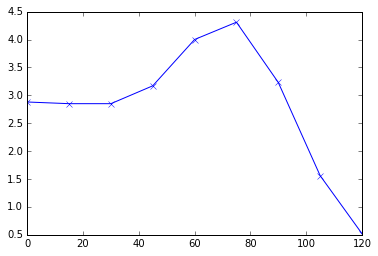

In [51]:
data_path = '../../data/ngc7217'
r_g_dens, gas_dens = zip(*np.loadtxt(data_path + "/gas_density.dat", float))
plt.plot(r_g_dens, gas_dens, 'x-')

(0, 250)

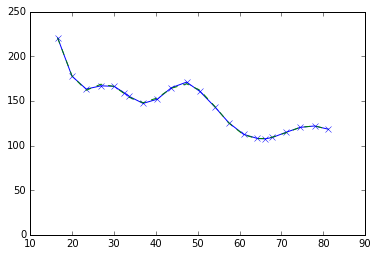

In [52]:
r_sig, sigR = zip(*np.loadtxt(data_path + "/silchenko_sigR.dat", float, delimiter=','))
poly_sig = poly1d(polyfit(r_sig, sigR, deg=11))
plt.plot(r_sig, sigR, 'x-')
plt.plot(r_sig, poly_sig(r_sig), '--')
plt.ylim(0, 250)

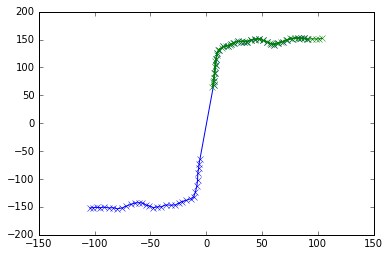

In [53]:
r_v, vel = zip(*np.loadtxt(data_path + "/silchenko_vel_g_approx.dat", float, delimiter=','))
plt.plot(r_v, vel, 'x-')
plt.plot(map(abs, r_v), map(abs, vel), 'x-')

(0, 100.0)

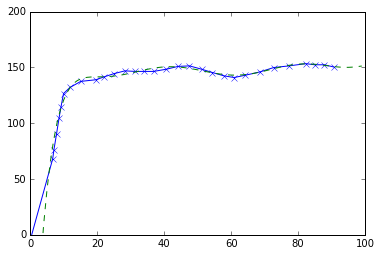

In [54]:
poly_gas = poly1d(polyfit(map(abs, r_v), map(abs, vel), deg=11))
plt.plot(r_v, vel, 'x-')
plt.plot(np.arange(0., 100., 1.), poly_gas(np.arange(0., 100., 1.)), '--')
plt.ylim(0)
plt.xlim(0)

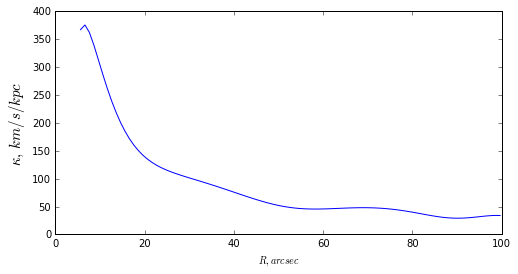

In [55]:
def epicyclicFreq_real(poly_gas, R, resolution):
    '''Честное вычисление эпициклической частоты на расстоянии R.'''
    return sqrt(2.0) * poly_gas(R) * sqrt(1 + R * poly_gas.deriv()(R) / poly_gas(R)) / (R * resolution )

test_points = np.arange(min(np.abs(r_v))+0.1, 100., 1.)

fig = plt.figure(figsize=[8, 4])
plt.plot(test_points, [epicyclicFreq_real(poly_gas, x, 0.072) for x in test_points], '-')
plt.xlabel('$R, arcsec$')
plt.ylabel('$\kappa,\, km/s/kpc$', fontsize=15)
plt.show()

15.0 1.08 194.224356299320 2.85
30.0 2.16 101.331621053555 2.85
45.0 3.24 62.5345986815690 3.17
60.0 4.32 45.6572574172413 4.0
75.0 5.4 45.5591937213943 4.31
90.0 6.48 29.0625059881457 3.23


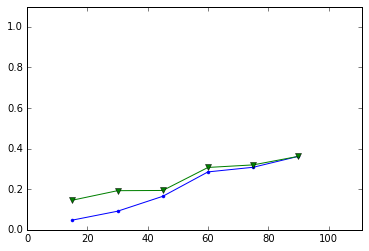

In [56]:
def model_star_dens(r):
    return 550*exp(-r/30.)

Qgs = []
Qss = []
invQeff = []
for r, gd in zip(r_g_dens, gas_dens)[1:-2]:
    print r, r*0.072, epicyclicFreq_real(poly_gas, r, 0.072), gd
    Qgs.append(Qg(epicycl=epicyclicFreq_real(poly_gas, r, 0.072), sound_vel=6., gas_density=gd*1.44))
    Qss.append(Qs(epicycl=epicyclicFreq_real(poly_gas, r, 0.072), sigma=poly_sig(r), star_density=model_star_dens(r)))
    qeff = findInvKinemQeffBrentq(Qss[-1], Qgs[-1], 6./poly_sig(r), np.arange(0.01, 60000., 1.))[1]
    invQeff.append(qeff)
    
plt.plot(r_g_dens[1:-2], map(lambda l: 1./l, Qgs), '.-')
plt.plot(r_g_dens[1:-2], invQeff, 'v-')
plt.ylim(0., 1.1)
plt.xlim(0., 8./0.072)
plt.show()

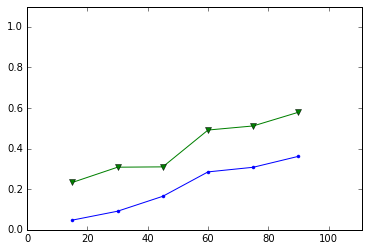

In [57]:
plt.plot(r_g_dens[1:-2], map(lambda l: 1./l, Qgs), '.-')
plt.plot(r_g_dens[1:-2], map(lambda l: 1.6*l, invQeff), 'v-')
plt.ylim(0., 1.1)
plt.xlim(0., 8./0.072)
plt.show()

Вообще не похоже